# Exploring the Statistics of Milk Production: Animal Classification

## Background

This notebook is intended to test hypotheses relating to animal classifications and milk production.  The collected data is from a single herd of dairy cattle.  The lactating portion of the herd is milked twice daily.  Animals who are in a dry period are not actively producing milk and are not included on those dates.  This analysis focuses on the relationships between linear classification scores and milk production. For a summary of these findings and others please see the [summary notebook](./stats-mini-project-summary.ipynb).

## Selected Terms

The following terms and definitions should be useful for understanding the contents of this analysis.  

- **Milk Weight:** The amount of milk produced by an animal.  Measured in pounds of milk. For reference, a gallon of milk weighs approximately 8.6 pounds.

- **Dry Period:** The period when a cow is not producing milk. Often serves as a time of rest following a lactation period.

- **Lactation Period:** The period when a cow is producing milk.

- **Days in Milk:** The number of consecutive days a given cow has been actively producing milk.

- **Linear Classification Score:** A integer score between 1-100 given to a milk cow, providing a numerical representation of how well a the physical attributes of an animal fits the profile of an 'ideal' milking cow.  A weighted summarization of 18+ assessments of a given animal.


## Linear Classification Score and Daily Average Milk Weight

### Hypotheses

- ~~**$H_{o Class}$:** The linear classication score is not linearly correlated with the average daily milk weight produced.~~
- **$H_{a Class}$:** The linear classication score is linearly correlated with the average daily milk weight produced.

### Results

The linear classification score score was found to be positively correlated with the average annual milk weight produced by a given dairy cow.  The correlation was found to be statistically significant.  This analyis suggest for every 1 point increase in final score the mean per day milk production is likely to increase by 0.14 pounds.

In [1]:
# Data Retrieval
import sys
sys.path.insert(0, '../scripts')
sys.path.insert(0, '../data/database')
from sqlalchemy import create_engine
import pandas as pd

In [2]:
def get_milk_and_scores():
    engine =  create_engine('sqlite:///../../data/database/happycows.db')
    with engine.connect() as con:
        milk = pd.read_sql_table('milk_volume', con)
        scores = pd.read_sql_table('classification', con)
    return milk, scores

In [3]:
milk, scores = get_milk_and_scores()
milk.head(3)

,index,date,animal_id,milk_weight,average_flow,max_flow,date_calved,days_since_calving
0,0,2015-07-03,200,61.3,3.70,5.0,NaT,NaN
1,1,2015-07-03,2017,71.2,4.45,8.1,2015-03-21,104.0
2,2,2015-07-03,2027,79.6,3.65,5.1,2015-06-10,23.0


In [4]:
scores.sample(3)

,index,animal_id,lactation_count,stature,strength,body_depth,dairy_form,rump_angle,rump_width,rear_legs_side,...,dairy_strength_aggregate,rump_aggregate,feet_and_legs_aggregate,udder_score_aggregate,final_score,age,breed_age_average,date_calved,date,category
414,66,2222.0,1.0,31.0,14.0,21.0,39.0,15.0,25.0,26.0,...,86.0,75.0,81.0,84.0,83.0,4-Feb,107.400002,2017-03-18,2017-07-10,Good Plus
386,38,2173.0,1.0,42.0,29.0,35.0,19.0,5.0,29.0,35.0,...,81.0,70.0,84.0,83.0,83.0,8-Feb,106.699997,2016-12-01,2017-07-10,Good Plus
273,45,2063.0,1.0,34.0,20.0,21.0,28.0,26.0,26.0,41.0,...,83.0,84.0,77.0,77.0,79.0,8-Feb,101.699997,2015-10-07,2016-05-09,Good


In [5]:
# Data Preparation: Average Daily Milk Volumes Per Animal
def select_features(data):
    return data[['date', 'animal_id', 'milk_weight']].dropna(axis=0, how='all')
    
full_milk = select_features(milk)
milk = full_milk.groupby('animal_id').mean()['milk_weight'].reset_index()
milk.sample(3)

,animal_id,milk_weight
10,1531,89.753582
214,2096,61.919469
338,2282,55.012281


In [6]:
# Data Preparation Classification Data
def select_features(data):
    return data[['animal_id', 'final_score', 'category']].dropna(axis=0, how='any')

scores = select_features(scores)
scores.sample(3)

,animal_id,final_score,category
160,1977.0,80.0,Good Plus
188,1608.0,87.0,Very Good
53,1887.0,80.0,Good Plus


In [7]:
# Merge data for analysis
milk_and_score = pd.merge(left=milk, right=scores, left_on='animal_id', right_on='animal_id')
full_milk_and_score = pd.merge(left=full_milk, right=scores, left_on='animal_id', right_on='animal_id')
milk_and_score.sample(3)

,animal_id,milk_weight,final_score,category
272,2074,64.089159,85.0,Very Good
86,1892,96.779310,78.0,Good
70,1876,88.050699,80.0,Good Plus


In [8]:
%matplotlib inline 

import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/Users/bcbeidel/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


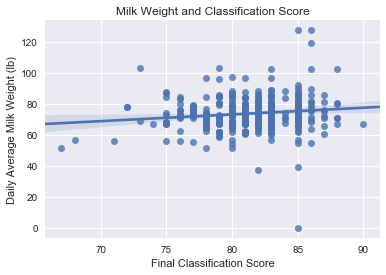

In [9]:
_ = sns.regplot(y="milk_weight", x="final_score", data=milk_and_score, fit_reg = True)
_ = plt.xlabel('Final Classification Score')
_ = plt.ylabel('Daily Average Milk Weight (lb)')
_ = plt.title('Milk Weight and Classification Score')

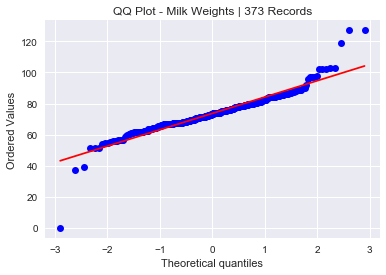

In [10]:
_ = stats.probplot(milk_and_score['milk_weight'], plot=plt)
_ = plt.title(f'QQ Plot - Milk Weights | {len(milk_and_score["milk_weight"])} Records')
plt.show()

## Analysis: Final Score and Milk Weight

In [11]:
import numpy as np

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

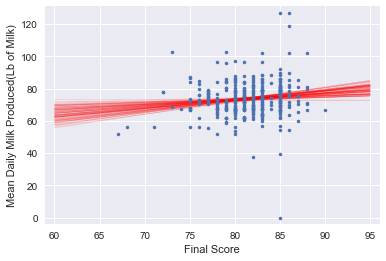

In [12]:
# Pairs bootstrapping and scatter plot between final score and milk weight
bs_slopes, bs_intercepts = draw_bs_pairs_linreg(milk_and_score['final_score'], milk_and_score['milk_weight'], 1000)

# Generate array of x-values for bootstrap lines: x
x = np.array([60, 95])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, bs_slopes[i]*x + bs_intercepts[i],
                 linewidth=0.5, alpha=0.2, color='red')

_ = plt.plot(milk_and_score['final_score'], milk_and_score['milk_weight'], marker='.', linestyle='none')
_ = plt.margins(0.03)
_ = plt.xlabel('Final Score')
_ = plt.ylabel('Mean Daily Milk Produced(Lb of Milk)')
plt.show()

Given the variance in the line of best fit, we continue our analysis the Pearson Correlation Coefficient and associated p-value to see if we can reject the null hypothesis for breed age average and the total milk weight from 2016.

In [13]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0,1]

In [14]:
def calculate_correlation_and_p_value(x, y, permutations=10000, alpha=0.05):
    obs_r = pearson_r(x, y)
    perm_replicates = np.empty(permutations)
    for i in range(permutations):
        y_permutated = np.random.permutation(y)
        perm_replicates[i] = pearson_r(x, y_permutated)
    
    p = np.sum(perm_replicates >= obs_r) / len(perm_replicates)
    
    print(f'     r = {obs_r}')
    print(f' p-val = {p}')
    print(f' alpha = {alpha}\n')
    if p < alpha:
        print("The correlation is statistically significant at this p-value and alpha level.")
    else:
        print("The correlation is not statistically significant at this p-value and alpha level.")
    
    return obs_r, p

In [15]:
r, p = calculate_correlation_and_p_value(milk_and_score['final_score'], milk_and_score['milk_weight'])

     r = 0.13401729371330617
 p-val = 0.006
 alpha = 0.05

The correlation is statistically significant at this p-value and alpha level.


## Conclusion: Final Score and Milk Weight

With a positive correlation coefficent and a p-value < 0.05 we can reject the following null hypothesis (Ho), and infer that the paired alternative hypothesis (Ha) is true:

- ~~**$H_{o Class}$:** The linear classication score is not linearly correlated with the average daily milk weight produced.~~
- **$H_{a Class}$:** The linear classication score is linearly correlated with the average daily milk weight produced.

An animal's final classification score was found to be positively, linearly correlated with the mean daily milk produced.  This analyis suggest for every 1 point increase in final score the mean per day milk production should increase by 0.14 pounds.